# Controls

Necessary packages:
1. AER (if in anaconda package manager, search 'r-aer')
2. glmnet (if in anaconda package manager, search 'r-glmnet')
3. Matrix (if in anaconda package manager, search 'r-matrix')

## Coditional Ignorability

Coditional Ignorability (CI) implies that you have observed all of the variables that influence both the treatment and the response. While it is impossible to control everything, the hope is that enough _main_ factors can be controlled for such that the results are _believable_.

To rentroduce the idea of controls, we will refer back to the oj.csv dataset to run the regression log(sales) against log(price) with three different types of available oj brands. We will run three regressions:
1. Basefit to demonstrate a regression without controlling for oj brand type.
2. Brandfit to demonstrate a multiple linear regression that includes a control for brand type.
3. Partial Linear Treatment Effects

### Partial Linear Treatment Effects (PLTE)

This is a structural model for conditional ignorability in that we regress a treatment variable (d) and a response of interest (y) on a set of covariates (x) that influence the treatment and the response. The structural model appears as follows:

#### Route 1
1. Regress confounders on treatment variable (d) \begin{align} d = x'\tau + v \end{align} where v is independent of $\epsilon$
2. Obtain fitted values for $\hat{d}$
3. Regress y on fitted values of treatment, observed treatment values, and confounders \begin{align} y = \hat{d}\theta + d\gamma + x'\beta + epsilon \end{align}
where $\epsilon$ is independent of d

#### Route 2

We know that $\hat{v} = d - \hat{d}$ so PLTE can also work by

1. Regress treatment variable on confounders (d)  \begin{align} d = x'\tau + v \end{align} where v is independent of $\epsilon$
2. Obtain fitted residuals for $\hat{d}$ noted as $\hat{v}$ 
3. Regress y on fitted residuals of treatment variable and confounders \begin{align} y = \hat{v}\gamma + x'\beta + epsilon \end{align}
where $\epsilon$ is independent of d



In [1]:
#Set the working directory to the specific location of the files on your computer
#note: In this case, the working directory was set for my computer
setwd("/Users/Brandon/Harding_ML_Class")

#set graphical parameters (this is only needed for jupyter notebooks)
options(repr.plot.width = 10, repr.plot.height = 5)

#### Localized Linear Regression: Fit a linear regression to each window

In [2]:
#Read in the data
oj <- read.csv("oj.csv")

In [3]:
#Regress log(sales) on log(price) without controlling for brand
basefit <- lm(log(sales) ~ log(price), data=oj)
coef(basefit)

(Intercept)  log(price) 
  10.423422   -1.601307

In [4]:
#Regress log(sales) on log(price) WITH controlling for brand
brandfit <- lm(log(sales) ~ brand + log(price), data=oj)
coef(brandfit)

(Intercept) brandminute.maid   brandtropicana       log(price) 
      10.8288216        0.8701747        1.5299428       -3.1386914

In [5]:
##Perform PLTE model

#Route 1:

#Refer to log(price) as treatment d and regress log(price) first against covariates brand
pricereg <- lm(log(price) ~ brand, data=oj)

#Obtain fitted values for log(price) and residuals
phat <- predict(pricereg, newdata=oj)

#Regress residuals onto log(sales) and extract coefficient
coef( residfit <- lm( log(sales) ~ phat + log(price) + brand, data=oj) )

##note: look at coefficient on log(price)

(Intercept)             phat       log(price) brandminute.maid 
      9.24059225       3.01389953      -3.13869143       0.07535709 
  brandtropicana 
              NA

In [6]:
##Perform PLTE model

#Route 2:

#Refer to log(price) as treatment d and regress log(price) first against covariates brand
pricereg <- lm(log(price) ~ brand, data=oj)

#Obtain  residuals
phat <- predict(pricereg, newdata=oj)
presid <- log(oj$price)-phat

#Regress residuals onto log(sales) and extract coefficient
coef( residfit <- lm( log(sales) ~ presid + brand, data=oj) )

#note: look at coefficient on phat and that exactly matches the coefficient on log(price) above

(Intercept)           presid brandminute.maid   brandtropicana 
      9.17483089      -3.13869143       0.04244730      -0.06334798

## High Dimensional Confounder Adjustment

To understand this concept, we will work through an example that asks the question: Easier access to abortion causes decreased crime?

The response variable $y_{st}$ is murder rate logged in state s at year t. The treatment variable $d_{st}$ is an effective abortion rate, measured in terms of number of legal abortions per 10 live births.

The list of confounders $x_{st}$ is prison, police, ur, inc, pov, AFDC, gun, and beer:

prison: log of lagged prisoners per capita
police: the log of lagged police per capita
ur: the unemployment rate
inc: per-capita income
pov: the poverty rate
AFDC: generosity at year t-15
gun: dummy for concealed weapons law
beer: beer consumption per capita 


The abortion 'a_' variables are weighted average of abortion rates where weights are determined by the fraction of the type of crime committed by various age groups. For example, if 60% of violent crime were committed by 18 year olds and 40% were committed by 19 year olds in state i, the abortion rate for violent crime at time t in state i would be constructed as .6 times the abortion rate in state i at time t − 18 plus .4 times the abortion rate in state i at time t − 19. See Donohue and Levitt (2001) for further detail.

Thus, we will work to estimate the model:

### \begin{align} \mathbb{E}[y_{st}] = \alpha_s + t\delta_t + d_{st}\gamma + x'_{st}\beta \end{align}

In [17]:
#Import data
data <- read.table("abortion.dat", skip=1, sep="\t")
names(data) <- c("state","year","pop","y_viol","y_prop","y_murd",
    "a_murd","a_viol","a_prop",'prison','police',
    'ur','inc','pov','afdc','gun','beer')

In [18]:
#Clean data
data <- data[!(data$state%in%c(2,9,12)),] # AK, DC, HA are strange places
data <- data[data$year>84 & data$year<98,] # incomplete data outside these years
data$pop <- log(data$pop)
t <- data$year - 85
s <- factor(data$state) ## the states are numbered alphabetically

In [19]:
str(data)

'data.frame':	624 obs. of  17 variables:
 $ state : int  1 1 1 1 1 1 1 1 1 1 ...
 $ year  : int  85 86 87 88 89 90 91 92 93 94 ...
 $ pop   : num  8.29 8.29 8.3 8.3 8.3 ...
 $ y_viol: num  1.53 1.73 1.74 1.75 1.8 ...
 $ y_prop: num  3.56 3.63 3.68 3.71 3.72 ...
 $ y_murd: num  -2.31 -2.28 -2.36 -2.29 -2.26 ...
 $ a_murd: num  0.00086 0.00135 0.00525 0.00968 0.02221 ...
 $ a_viol: num  0.00915 0.0141 0.03155 0.05182 0.08807 ...
 $ a_prop: num  0.0362 0.0551 0.105 0.1633 0.2502 ...
 $ prison: num  0.953 0.995 1.058 1.144 1.122 ...
 $ police: num  0.763 0.791 0.819 0.88 0.941 ...
 $ ur    : num  0.0891 0.0983 0.0777 0.0721 0.0703 ...
 $ inc   : num  9.7 9.75 9.76 9.78 9.8 ...
 $ pov   : num  20.6 23.8 21.3 19.3 18.9 19.2 18.8 17.1 17.4 16.4 ...
 $ afdc  : num  3078 2806 3456 3210 3789 ...
 $ gun   : int  1 1 1 1 1 1 1 1 1 1 ...
 $ beer  : num  18.7 19.3 19.4 19.4 19.4 20.1 20.1 20.4 20.3 21 ...


In [20]:
##Extract the controls, treatment, and response variables

#Extract the controls
controls <- data.frame(data[,c(3,10:17)])

## y is de-trended log crime rate, a is as described below
## note we also have violent and property crime versions
y <- data$y_murd
d <- data$a_murd

In [21]:
head(controls)

,pop,prison,police,ur,inc,pov,afdc,gun,beer
20,8.287277,0.9526656,0.7626628,0.08908,9.703193,20.6,3077.629,1,18.7
21,8.292048,0.9952912,0.7909027,0.09833,9.745950,23.8,2805.778,1,19.3
22,8.297793,1.0584020,0.8189143,0.07775,9.762092,21.3,3455.742,1,19.4
23,8.300032,1.1438180,0.8803344,0.07208,9.781770,19.3,3210.000,1,19.4
24,8.301522,1.1219460,0.9410318,0.07025,9.802527,18.9,3789.493,1,19.4
25,8.306472,1.2144630,0.9891075,0.06775,9.814290,19.2,3436.729,1,20.1


In [22]:
#Use OLS to fit the regression above
orig <- glm(y ~ d + t + s +., data=controls)

#View model summary
summary(orig)$coef['d',]
beta_orig <- summary(orig)$coef['d',"Estimate"]

#NOTE: This result differs from textbook.

Estimate    Std. Error       t value      Pr(>|t|) 
-2.098119e-01  4.109177e-02 -5.105936e+00  4.505925e-07

In [23]:
#We find that 100 more abortions per 1000 live births leads to a 19% reduction in the per-capita murder rate
round(1 - exp(beta_orig),2)

[1] 0.19

#### This is the levitt analysis: higher abortion leads to lower crime. That abortion is only one factor influencing crime in the late 1980s points out the caution required in drawing any conclusions regarding an abortion-crime link based on time series evidence alone.

#### Consider the alternative story that cellphone use has caused lower murder rates. Note that the phone variable is the aggregate US rate in this model). We will work to estimate the model:

### \begin{align} \mathbb{E}[y_{st}] = \alpha_s + t\delta_t + \gamma (phone)+ x'_{st}\beta \end{align}

In [24]:
#Import cellphone data
cell <- read.csv("us_cellphone.csv")

# center on 1985 and scale by 1997-1985
cellrate <- 5*cell[,2]/(1000*cell[,3])

In [25]:
#Perform regression
phone <- cellrate[t+1]
tech <- glm(y ~ phone + s + t +., data=controls)
summary(tech)$coef['phone',]

Estimate    Std. Error       t value      Pr(>|t|) 
-3.720723e-01  6.932262e-02 -5.367257e+00  1.168637e-07

In [26]:
#Adding one cellphone per every 5 americans results in a 31% drop in the murder rate
beta_tech <- summary(tech)$coef['phone',"Estimate"]
round(1 - exp(beta_tech),2)

[1] 0.31

#### Let's now view a plot of US abortion and cellphone rates during our sample.

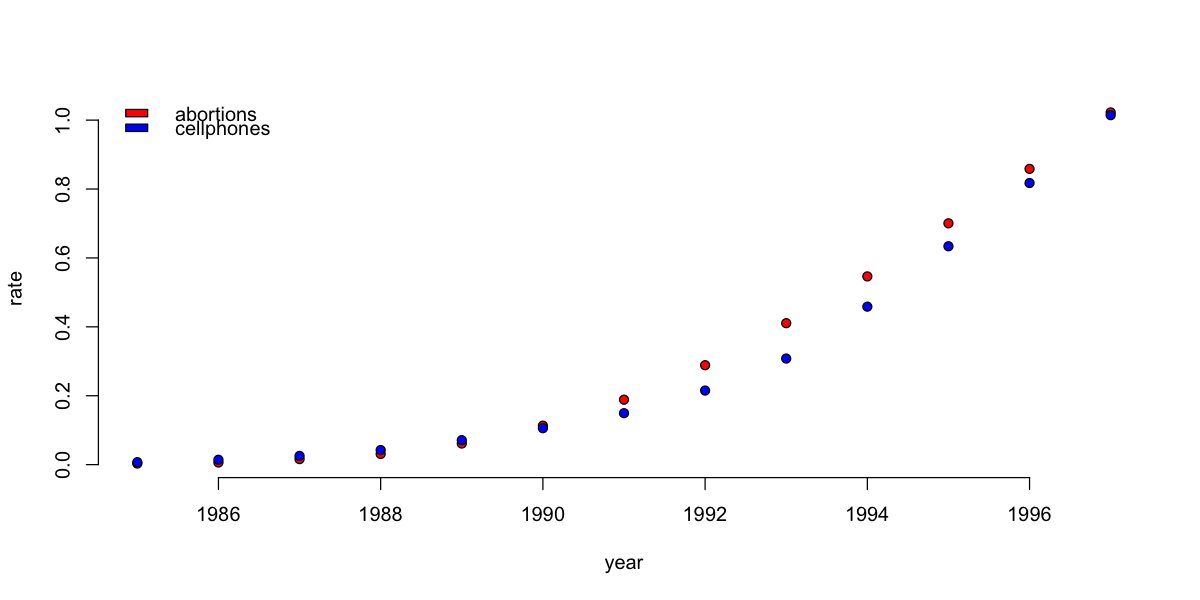

In [27]:
#Construct plot
plot(1985:1997, tapply(d, t, mean), bty="n", xlab="year", ylab="rate", pch=21, bg=2)
points(1985:1997, cellrate, bg=4, pch=21)
legend("topleft", fill=c(2,4), legend=c("abortions","cellphones"), bty="n")

#### What is happening here is that murder has been increasing quadratically, and we have no other controls that do so.  To be correct, you need to allow quadratic trends that could be caused by other confounding variables (e.g. technology). We also allow interaction between the controls, and interact the nation-wide phone variable with state dummies to allow for state specific tech adoption.

### \begin{align} \mathbb{E}[y_{st}] = \alpha_s + t\delta_t + d_{st}\delta + \gamma(phone) + \theta(phone_s) + x'_{st}\beta \end{align}

In [28]:
#Perform the regression
t <- factor(t)
interact <- glm(y ~ d + t + phone*s + .^2, data=controls)
summary(interact)$coef["d",]

Estimate Std. Error    t value   Pr(>|t|) 
 0.2797107  0.1807311  1.5476619  0.1223753

In [29]:
#### Treatment variable d (number of abortions) is no longer significant as n is roughly equal to p
dim(model.matrix(formula(interact), data=controls))

[1] 624 154

## Better Control for Confounders by  Modeling Treatment Assignment Process

### PLTE Lasso Regression

This follows from the PLTE framework above and works in a stepwise fashion. Look to pg163 in textbook for more details.
1. Use a CV or AICc Lasso regress the treatment allocation against any potential confounders and collect the fitted values for treatment allocation. ($\hat{d}_i = \mathbb{E}[d|x] = f(x'\tau)$)
2. Use a second CV or AICc lasso to estimate
\begin{align} \mathbb{E}[y|x,d] = \hat{d}\theta + d\gamma + x'\beta \end{align}
with no penalty on $\theta$

Thus, $\hat{\gamma}$ is the treatment effect estimate of d on y.

#### Recall the abortion and cellphone example from the last section. let's use the PTLE lasso regression to model data.

In [30]:
#Refactor state to have NA reference level
sna <- factor(s, levels=c(NA,levels(s)), exclude=NULL)

In [31]:
#Generate a sparse model matrix
library(Matrix)
x <- sparse.model.matrix( ~ t + phone*sna + .^2, data=controls)[,-1]
dim(x)

[1] 624 154

In [32]:
#Perform naive lasso regression
library("glmnet")
naive <- cv.glmnet(cBind(d,x),y,nfolds=5)
coef(naive)["d",] # effect is CV selected <0

Loading required package: foreach
Loaded glmnet 2.0-16

Warning message:
“'cBind' is deprecated.
 Since R version 3.2.0, base's cbind() should work fine with S4 objects”

[1] -0.1211411

In [33]:
##Perform PTLE lasso regression

#Regress treatment variable on confounders
treat <- cv.glmnet(x,d, lambda.min.ratio=1e-4, nfolds=5)

#Get fitted residuals
dhat <- drop( predict(treat, x, select="min") )

#Look at correlation between d and dhat
cor(drop(dhat),d)^2

[1] 0.9803621

#### Notice that the plot below demonstrates that dhat covers most of d.

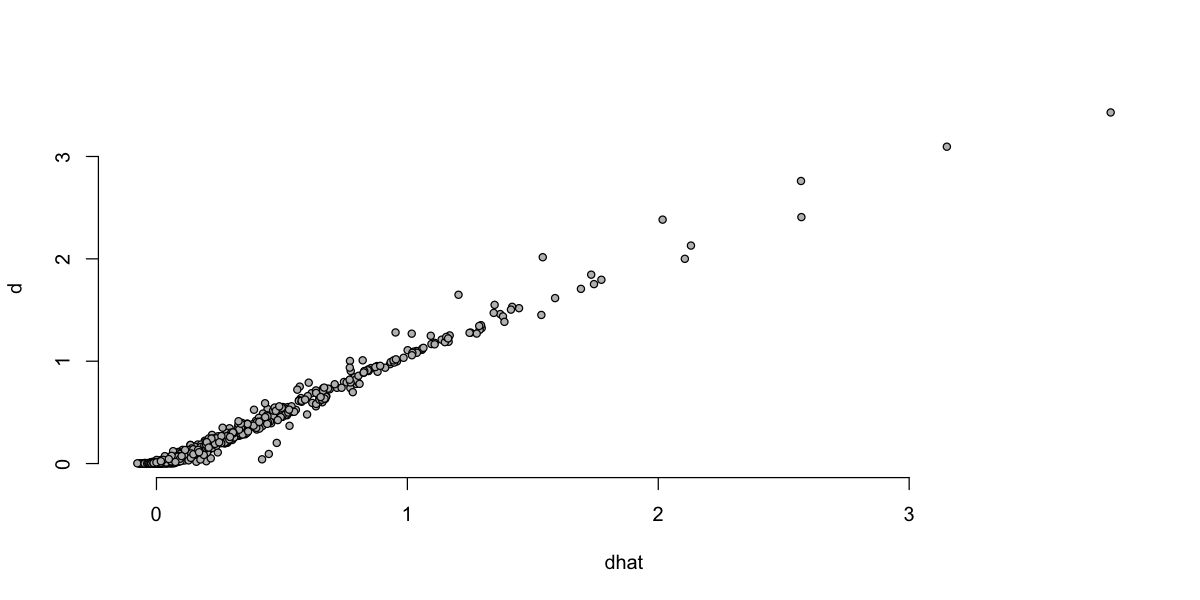

In [34]:
#Plot dhat
plot(dhat,d,bty="n",pch=21,bg=8, cex=.8, yaxt="n")
axis(2, at=c(0,1,2,3)) 

#### Now run lasso regression with d, dhat, and confounders and no penalty on dhat

In [35]:
##In glmnet, we set variables to exclude from penalty by setting their penalty.factor=0
# note: variables with penalty.factor=1 are treated normally, and penalty.factor=inf are excluded from modeling

#Create a vector of repeating ones of length of x plus 2 for d and dhat
p.fac <- rep(1,(ncol(x) + 2))

#Set the second item in the p.fac vector equal to zero such that dhat has no penalty
p.fac[2] <- 0

In [36]:
### Re-run lasso, with this (2nd column) included unpenalized
causal <- cv.glmnet(cBind(d,dhat,x),y,penalty.factor=p.fac,lambda.min.ratio=1e-4, nfolds=5)
coef(causal, select="min")["d",]

[1] 0

## Sample Splitting and Orthogonal Machine Learning

PTLE Lasso regression can give good point estimates for treatment effects, yet lack in providing good standard errors for inferential analysis. Even a nonparametric bootstrap leads to less satifactory results in this case. However, a multiple stage approach using sample splitting can accomplish the task. In this sample splitting approach, the data is split for example into two pieces where th emodel is selected on one piece, and conditional upon the selected model, standard inference is done on the other piece.

#### We return to the abortion example from above.

### Double ML for PTLE

This algorithm provides a general technique for sample splitting with high dimensional controls. The algorithm is as follows:
1. Split the data into K random and roughly equivalenrt folds
2. Nuisance estimation: (a) estimate $\hat{\mathbb{E}}[d|x]$ and $\hat{\mathbb{E}}[y|x]$ using all data but kth fold and (b) then calculate out of sample residuals for k-th fold
3. Fit OLS regression onto the OOS residuals from step 2 and fit \begin{align} \mathbb{E}[\tilde{y}|\tilde{d}] = \alpha + \tilde{d}\gamma \end{align}
4. Take resulting $\hat{\gamma}$ with heteroskedastic consistent standard errors to get confidence interval for treatment effect

In [39]:
#Define a function orthoPLTE to perform Double ML to PTLE
library('AER')

orthoPLTE <- function(x, d, y, dreg, yreg, nfold=2)
{
    # Step 1: randomly split data into folds
    nobs <- nrow(x)
    foldid <- rep.int(1:nfold, 
        times = ceiling(nobs/nfold))[sample.int(nobs)]
    I <- split(1:nobs, foldid)
    
    # create residualized objects to fill
    ytil <- dtil <- rep(NA, nobs)
    
    # Step 2: run the OOS orthogonalizations
    cat("fold: ")
    for(b in 1:length(I)){
        #Treatment Regression
        dfit <- dreg(x[-I[[b]],], d[-I[[b]]])
        #Response regression
        yfit <- yreg(x[-I[[b]],], y[-I[[b]]])
        
        #calculate fitted values of above regressions
        dhat <- predict(dfit, x[I[[b]],], type="response")
        yhat <- predict(yfit, x[I[[b]],], type="response")
        
        #Calculate and store residuals of above regressions
        dtil[I[[b]]] <- drop(d[I[[b]]] - dhat)
        ytil[I[[b]]] <- drop(y[I[[b]]] - yhat)
        cat(b," ")
    }
    
    #Step 3: Fitted regression of residuals from step 2
    rfit <- lm(ytil ~ dtil)
    gam <- coef(rfit)[2]
    
    #Calculate standard errors
    se <- sqrt(vcovHC(rfit)[2,2])
    cat(sprintf("\ngamma (se) = %g (%g)\n", gam, se))

    return( list(gam=gam, se=se, dtil=dtil, ytil=ytil) )
}

Loading required package: car
Loading required package: carData
Loading required package: lmtest
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Loading required package: sandwich
Loading required package: survival


In [40]:
##Use above function with glmnet

#Define dreg and yreg
dreg <- function(x,d){ cv.glmnet(x, d, lambda.min.ratio=1e-5, nfolds=5) }

yreg <- function(x,y){ cv.glmnet(x, y, lambda.min.ratio=1e-5, nfolds=5) }

#Run orthoPLTE
resids <- orthoPLTE( x=x, d=d, y=y, 
                    dreg=dreg, yreg=yreg, nfold=5)

fold: 1  2  3  4  5  
gamma (se) = -0.0335877 (0.107443)


### Look to hockey_ortho.R script for sample splitting and double ml for ptle applied to the hockey example.

## Demand Analysis

We can utilize the PTLE model to estimate short-term price elasticities. Where elasticity is
### \begin{align} \gamma = \frac{\frac{\Delta q}{q}}{\frac{\Delta p}{p}} = \frac{p \Delta q}{q \Delta p} \end{align}

#### We will work through an example of sales of beer at Dominick's store to discuss the application of PTLE for demand analysis.

# ^^^CODE IS NOT GOOD FOR THIS SECTION (Demand Analysis)^^^^

I believe the dataset to use is dominick_beer.R but nothing matches to that of the textbook. My feeling is that the dataset is incomplete and missing the first 91 weeks of observation. Further, the r-script is confusing into relation of the script used in the chapter. Potentially, the r-script and data is missing altogether for this section.

## Synthetic Controls

We will use a dataset that concerns the economic costs of terrorism is the Basque region of Spain to work through the synthetic controls algorithm. The synthetic controls algorithm works by
1. Building a regression model to predict $\mathbb{E}[y_{1t}(0)|y_{-1t}(0)]$ and estimate it for periods=t...T
2. Use the step 1 regression to predict $\hat{y}_{1T+1}(0)$, $\hat{y}_{1T+2}(0)$, etc. and estimate the treatment effect at each point in time as
\begin{align} \hat{\gamma}_{1T+s} = \y_{1T+s}(1) - \hat{y}_{1T+s}(0)


#### Code for this section is in the basque_commented.R script file.